# Aligning Parameters

In this notebook we are taking one language (for example Spanish), reading the output from ExtractNamedTempates and:

* Counting templates frequency
* Counting parameters frequency
* Getting the pages where templates occurs
* Getting a second language (Ex: Catalan), trying to find the equivalent template (using Wikidata)
* Comparing the paramers and values in those pairs of language

## Define basic functions

In [626]:
%matplotlib inline
from matplotlib import pyplot
import requests
import json
import mwparserfromhell


def getWikidataPair(titles,lang,target):
    """
    titles: list of pages titles
    lang:source lang (same of the titles)
    target: target lang
    returns a list: page_title_source,page_title_target
    """
    response= requests.get("https://www.wikidata.org/w/api.php?action=wbgetentities&sites=%swiki&titles=%s&props=sitelinks&format=json" % (lang,'|'.join(titles)))
    output = []
    for entity,data in  response.json()['entities'].items():
        if data['sitelinks'].get(target+'wiki'):
            s=data['sitelinks'][lang+'wiki']['title']
            t=data['sitelinks'][target+'wiki']['title']
            output.append([s,t])
    return output

def getWikidataID(titles,lang):
    """
    titles: list of pages titles
    lang:source lang (same of the titles)
    target: target lang
    returns a list: page_title_source,page_title_target
    """
    response= requests.get("https://www.wikidata.org/w/api.php?action=wbgetentities&sites=%swiki&titles=%s&props=sitelinks&format=json" % (lang,'|'.join(titles)))
    output = []
    for entity,data in  response.json()['entities'].items():
        if data['sitelinks'].get(target+'wiki'):
            s=data['sitelinks'][lang+'wiki']['title']
            t=data['sitelinks'][target+'wiki']['title']
            output.append([s,t])
    return output


#Get articles
def getContent(title,lang):
    """
    title: page title
    lang: lang
    returns wikitext
    """
    url = "https://%s.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=json&formatversion=2&titles=%s" % (lang,title)
    response = requests.get(url)
    content = response.json()['query']['pages'][0]['revisions'][0]['content']
    return content

#get all the templates with named parameters
def extract_templates(text):
    wikicode = mwparserfromhell.parse(text)
    tmpdict = {}
    for template in wikicode.filter_templates():
        if template.params:
            values = dict([[t.name.strip(),t.value.strip()] for t in template.params if t.showkey])
            if values:
                tmpdict[template.name.strip()] = values
    return tmpdict

def getTemplateData(template,lang):
    url =  "https://%s.wikipedia.org/w/api.php?action=templatedata&titles=%s&formatversion=2&redirects=1" % (lang,template)
    #print(url)
    resp = requests.get(url)
    data = list(resp.json()['pages'].values())[0]
    return data


def apply_transform(vec, transform):
        """
        Apply the given transformation to the vector space

        Right-multiplies given transform with embeddings E:
            E = E * transform

        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        return np.matmul(vec, transmat)


## Aggregating templates coming from ExtractNamedTempates.ipynb

Note that all templantes name are capitalized and parameters are in low case

In [367]:
lang = 'es'
f = open('templates-articles_%s.json' % lang)
templates = {}
params = {}
for l in f:
    tmp = json.loads(l)
    page = tmp[1]
    for template,param in tmp[2].items():
        template = template.capitalize()
        templates[template] = templates.get(template,{'Tcount':0,'Tpages':[],'Params':{}})
        templates[template]['Tcount'] += 1
        templates[template]['Tpages'].append(page)
        for name,val in param.items():
            name = name.lower()
            templates[template]['Params'][name] =templates[template]['Params'].get(name,0)
            templates[template]['Params'][name] +=1
            params[name] = params.get(name,0)
            params[name] += 1

In [368]:
targetLang = 'en'
f = open('templates-articles_%s.json' % targetLang)
templatesTarget = {}
paramsTarget = {}
for l in f:
    tmp = json.loads(l)
    page = tmp[1]
    for template,param in tmp[2].items():
        template = template.capitalize()
        templatesTarget[template] = templatesTarget.get(template,{'Tcount':0,'Tpages':[],'Params':{}})
        templatesTarget[template]['Tcount'] += 1
        templatesTarget[template]['Tpages'].append(page)
        for name,val in param.items():
            name = name.lower()
            templatesTarget[template]['Params'][name] =templatesTarget[template]['Params'].get(name,0)
            templatesTarget[template]['Params'][name] +=1
            paramsTarget[name] = paramsTarget.get(name,0)
            paramsTarget[name] += 1

## Getting most frequent templates and parameters

In [114]:
templateFreq = [(a[0],a[1]['Tcount'],len(a[1]['Params'])) for a in sorted(templates.items(), key =  lambda x:x[1]['Tcount'],reverse=True)]
templateFreq = [(a[0],a[1]['Tcount'],len(a[1]['Params'])) for a in sorted(templates.items(), key =  lambda x:x[1]['Tcount'],reverse=True)]

In [333]:
templateFreq[0:50]

[('Listaref', 618206, 17467),
 ('Cita web', 474422, 770),
 ('Ficha de entidad subnacional', 256644, 2003),
 ('Ficha de taxón', 166540, 464),
 ('Cita libro', 159579, 687),
 ('Ficha de deportista', 120360, 1181),
 ('Cita publicación', 89720, 925),
 ('Cita noticia', 81953, 260),
 ('Ficha de persona', 68685, 2285),
 ('Coord', 67812, 81),
 ('Referencias', 66815, 484),
 ('Commonscat', 66446, 4925),
 ('Enlace roto', 64063, 212),
 ('Sucesión', 47983, 144),
 ('Altura', 46017, 14),
 ('Wayback', 38548, 15),
 ('Cite web', 36285, 255),
 ('Evolución demográfica', 36199, 214),
 ('Peso', 33365, 16),
 ('Ficha de artista musical', 28863, 1256),
 ('Control de autoridades', 27633, 3083),
 ('Ficha de álbum', 26938, 495),
 ('Wikispecies', 26675, 678),
 ('Gráfica de evolución', 25393, 141),
 ('Ficha de película', 25351, 1334),
 ('Ficha de actor', 23706, 1134),
 ('Ficha de autoridad', 22795, 1458),
 ('Esp', 22403, 5693),
 ('!', 21445, 1614),
 ('Traducido ref', 20612, 34),
 ('Iucn', 19424, 137),
 ('Biology cat

In [121]:
### looking for errors or unsual parameters
!grep --color=always "05.22.2012 acessodata" templates-articles_es.json

[7028454, "Oswaldo de Oliveira", {"JPN": {"05.22.2012 acessodata": "", "url": "http://esporte.uol.com.br/futebol/ultimas-noticias/2012/05/22/campeao-mundial-em-2000-oswaldo-de-oliveira-revela-torcida-pelo-corinthians-na-libertadores.htm", "t\u00edtulo": "Campe\u00e3o mundo en 2000, Oswaldo de Oliveira revela animando para el Corinthians en la Libertadores", "fecha": "22 de mayo de 2012", "UOL autor": ""}, "cita web": {"05.22.2012 acessodata": "", "url": "http://esporte.uol.com.br/futebol/ultimas-noticias/2012/05/22/campeao-mundial-em-2000-oswaldo-de-oliveira-revela-torcida-pelo-corinthians-na-libertadores.htm", "t\u00edtulo": "Campe\u00e3o mundo en 2000, Oswaldo de Oliveira revela animando para el Corinthians en la Libertadores", "fecha": "22 de mayo de 2012", "UOL autor": ""}, "BRA": {"05.22.2012 acessodata": "", "url": "http://esporte.uol.com.br/futebol/ultimas-noticias/2012/05/22/campeao-mundial-em-2000-oswaldo-de-oliveira-revela-torcida-pelo-corinthians-na-libertadores.htm", "t\u00

In [119]:
params['05.22.2012 acessodata']

6

In [103]:
sorted(params.items(), key =  lambda x:x[1],reverse=True)[0:20]

[('título', 1562403),
 ('url', 1365103),
 ('nombre', 1207457),
 ('fechaacceso', 989163),
 ('imagen', 760567),
 ('fecha', 560491),
 ('idioma', 559346),
 ('editorial', 525433),
 ('año', 332830),
 ('país', 311879),
 ('mapa_loc', 297768),
 ('autor', 285270),
 ('tipo', 284640),
 ('obra', 275157),
 ('tipo_superior_1', 274436),
 ('superior_1', 274310),
 ('familia', 250356),
 ('tipo_superior_2', 244119),
 ('superior_2', 244032),
 ('regnum', 243973)]

In [191]:
sorted(paramsTarget.items(), key =  lambda x:x[1],reverse=True)[0:20]


[('title', 7375352),
 ('date', 6180079),
 ('url', 5910723),
 ('accessdate', 3631953),
 ('publisher', 3471639),
 ('name', 2071099),
 ('website', 1666381),
 ('last', 1651820),
 ('first', 1603225),
 ('image', 1579853),
 ('year', 1298909),
 ('work', 1181458),
 ('caption', 1090437),
 ('display', 1051468),
 ('language', 989975),
 ('df', 989353),
 ('location', 961547),
 ('isbn', 782872),
 ('access-date', 734538),
 ('pages', 724679)]

## Experiments with some (arbitrary) selected templates

In [394]:
exampleTemplate = 'Ficha de persona'
sourceLang ='es'
targetLang = 'en'
templatesTwoLang = getWikidataPair(['Plantilla:'+exampleTemplate],sourceLang,targetLang)[0]

In [533]:
import random
random.seed(1)
pagesSource = random.sample(templates[exampleTemplate]["Tpages"],50)
pagesPairs = getWikidataPair(pagesSource,sourceLang,targetLang)
templatesPairsPerPage = {}
for pages in pagesPairs:
    templateSource = [(name,data) for name,data in  extract_templates(getContent(pages[0],sourceLang)).items() if name.lower() in templatesTwoLang[0].lower()] 
    templateTarget = [(name,data) for name,data in  extract_templates(getContent(pages[1],targetLang)).items() if name.lower() in templatesTwoLang[1].lower()] 
    if templateSource:
        if templateTarget:
            templatesPairsPerPage[pages[0]] = templatesPairsPerPage.get(pages[0],[])

            templatesPairsPerPage[pages[0]].append((templateSource,templateTarget))
    
    

## TemplateData (metadata) based aligments
Check distance 3, is the one working

### Using Josifoski et al alignments [https://arxiv.org/abs/1904.03922]

In [192]:
import numpy as np
from cr5 import Cr5_Model
from scipy.spatial import distance
from collections import Counter

model = Cr5_Model('./','joint_28') # path_to_pretrained_model, model_prefix
model.load_langs(['en', 'ca','es']) # list_of_languages


In [616]:
templatesTwoLang

['Plantilla:Ficha de persona', 'Template:Infobox person']

In [617]:

templateDataLang1 = getTemplateData(templatesTwoLang[0],sourceLang)
templateDataLang2 = getTemplateData(templatesTwoLang[1],targetLang)

https://es.wikipedia.org/w/api.php?action=templatedata&titles=Plantilla:Ficha de persona&formatversion=2&redirects=1
https://en.wikipedia.org/w/api.php?action=templatedata&titles=Template:Infobox person&formatversion=2&redirects=1


In [339]:
distances = {}
for param1,data1 in templateDataLang1['params'].items():
    try:
        vec1 = model.get_document_embedding(param1.split(),sourceLang)
        distances[param1] = []
        for param2,data2 in templateDataLang2['params'].items():
            if data1['type'] == data2['type']:

                try:
                    vec2 = model.get_document_embedding(param2.split(),targetLang)
                    dist = distance.cosine(vec1,vec2)
                    distances[param1].append([dist,param2])
                except:
                    pass
    except:
        pass
for param,words in distances.items():
    try:
        print(param,sorted(words)[0:3])
    except:
        pass

In [282]:
distances2= {}
for param1,data1 in templateDataLang1['params'].items():
    try:
        try:
            vec1 = model.get_document_embedding(data1['label'][sourceLang].split(),sourceLang)
        except:
            vec1 = model.get_document_embedding(param1.split(),sourceLang)

        distances2[param1] = []
        for param2,data2 in templateDataLang2['params'].items():
            if data1['type'] == data2['type']:
                try:
                    vec2 = model.get_document_embedding(data2['label'][targetLang].split(),targetLang)
                except:
                    vec2 = model.get_document_embedding(param2.split(),targetLang)
                try:
                    dist = distance.cosine(vec1,vec2)
                    distances2[param1].append([dist,param2])
                except:
                    pass
    except:
        pass
for param,words in distances2.items():
    try:
        print(param,sorted(words)[0:2])
    except:
        pass

patrimonio [[0.7989678076472049, 'landscape'], [0.8727741423780409, 'home_town']]
salario [[0.8603897133538129, 'agent'], [0.8739218184820586, 'notable_works']]
lengua_literaria [[0.8975119551941316, 'notable_works'], [0.9138415004503775, 'weight']]
religión [[0.9134964722950669, 'citizenship'], [0.9265505081034637, 'awards']]
pie de imagen [[0.08191621987909636, 'image'], [0.8524556653546729, 'signature_size']]
lugar de desaparición []
medio de comunicación []
padres [[0.7821614341801805, 'citizenship'], [0.8002728500807861, 'weight_kg']]
nombre nativo [[0.8054833941108615, 'home_town'], [0.82476407014545, 'body_discovered']]
educación [[0.3288765587743242, 'education'], [0.7549041514581039, 'baptised']]
cargo ocupado []
años activo [[0.9148833681527163, 'body_discovered'], [0.9395062880009897, 'caption']]
tamaño de imagen [[0.08191621987909636, 'image'], [0.8524556653546729, 'signature_size']]
apodo [[0.8478106902157878, 'influenced'], [0.8664304866672008, 'weight_kg']]
alternativa c

### Using Wikidata based alignemnts https://github.com/digitalTranshumant/wmf-interlanguage

In [291]:
## Trying my alignments

import fastText
myModel = fastText.load_model('fastText/wiki.es.bin')
myModel2 = fastText.load_model('fastText/wiki.en.bin')


In [327]:
distances3 = {}
transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')
for param1,data1 in templateDataLang1['params'].items():
        vec1 = myModel.get_sentence_vector(param1)
        distances3[param1] = []
        for param2,data2 in templateDataLang2['params'].items():
          #  if data1['type'] == data2['type']:
                vec2= myModel2.get_sentence_vector(param2)
                vec2T = apply_transform(vec2,transmat)
                dist = distance.cosine(vec1,vec2T)
                distances3[param1].append([dist,param2])

for param,words in distances3.items():
    try:
        if sorted(words)[0][0] < .4:
            print(param,sorted(words)[0:3])
    except:
        pass

salario [[0.34686267984318064, 'salary'], [0.5329042061310687, 'employer'], [0.5965979002841617, 'net_worth']]
padres [[0.2876338169892533, 'parents'], [0.4058660453093854, 'mother'], [0.4181208590909826, 'father']]
educación [[0.21443717063835965, 'education'], [0.6178690504391597, 'citizenship'], [0.6280876465303372, 'children']]
sucesor [[0.3365330269688752, 'successor'], [0.456283892848407, 'predecessor'], [0.618620802171814, 'father']]
nombre [[0.26619029141547823, 'name'], [0.6145292268664284, 'native_name'], [0.6246814849355296, 'callsign']]
nombre completo [[0.3834951969338314, 'name'], [0.6662905921800288, 'native_name'], [0.6776359587662848, 'pronunciation']]
residencia [[0.22379335319260452, 'residence'], [0.5994219355354917, 'resting_place_coordinates'], [0.6178789690657341, 'resting_place']]
peso [[0.36017355935521966, 'weight'], [0.49174267895300294, 'weight_kg'], [0.549960720560015, 'weight_lb']]
altura [[0.38311822276064533, 'height'], [0.5832588073048197, 'height_m'], 

### Template data limitations
* Big amount of 'es' templates, have no templatedata info

In [628]:
withTemplateData = 0
withoutTemplateData = 0
for t in templateFreq[0:50]:
    try:
        tmp = getTemplateData('Plantilla:'+t[0],lang='es')
        print(t[0],'ok')
        withTemplateData +=1
    except:
        print(t[0],'no')
        withoutTemplateData +=1
print(withTemplateData,'ok',withoutTemplateData,'No')

Listaref ok
Cita web ok
Ficha de entidad subnacional ok
Ficha de taxón no
Cita libro ok
Ficha de deportista no
Cita publicación ok
Cita noticia ok
Ficha de persona ok
Coord no
Referencias ok
Commonscat ok
Enlace roto ok
Sucesión ok
Altura no
Wayback no
Cite web ok
Evolución demográfica no
Peso no
Ficha de artista musical ok
Control de autoridades no
Ficha de álbum ok
Wikispecies ok
Gráfica de evolución no
Ficha de película ok
Ficha de actor ok
Ficha de autoridad ok
Esp no
! no
Traducido ref no
Iucn no
Biology catalog no
Usa no
Ficha de localidad de españa no
En no
Ficha de cuerpo celeste
<!-- encabezado --> no
Cite news ok
Bandera ok
Ficha de sencillo ok
Lista de canciones no
Sfn ok
Arg no
Ficha de organización no
Harvnp ok
Cite book ok
Cita requerida ok
Ficha de serie de televisión ok
Ficha de estación no
Mex no
Ficha de cuerpo de agua ok
27 ok 23 No


### Without Template Data
This is working pretty good. 
We need to:
* Play with the similiarty threshold
* Map 1 to 1 (keep just the most similar)

In [395]:
distancesNoTemplateData = {}
print(templatesTwoLang)
template1 = templates[templatesTwoLang[0].split(':')[1]]
template1['params'] = sorted(template1['Params'].items(), key= lambda x: x[1],reverse=True)[:100]
template2 = templatesTarget[templatesTwoLang[1].split(':')[1]]
template2['params'] = sorted(template2['Params'].items(), key= lambda x: x[1],reverse=True)[:200]


transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')
for param1,data1 in template1['params']:
    try:
        vec1 = myModel.get_sentence_vector(param1.strip())
        distancesNoTemplateData[param1] = []
    except: pass
    for param2,data2 in template2['params']:
            try:
                vec2= myModel2.get_sentence_vector(param2.strip())
                vec2T = apply_transform(vec2,transmat)
                dist = distance.cosine(vec1,vec2T)
                distancesNoTemplateData[param1].append([dist,param2])
            except:
                pass

cNotFound = 0
for param,words in distancesNoTemplateData.items():
    try:
        if sorted(words)[0][0] < .4:
            print(param,sorted(words)[0:3])
        else:
            cNotFound +=1
    except:
        pass
print(cNotFound,'Without Mapping')

['Plantilla:Ficha de persona', 'Template:Infobox person']
salario [[0.34686267984318064, 'salary'], [0.5329042061310687, 'employer'], [0.5914404969325433, 'networth']]
profesión [[0.2907516493035255, 'profession'], [0.6062218171219675, 'occupation'], [0.6481471582822792, 'father']]
almamáter [[0.20313075649282697, 'alma_mater'], [0.40838973184531924, 'university'], [0.4787241033567037, 'image_name']]
tamaño de imagen [[0.3487460935340897, 'image size'], [0.44899283918994626, 'image caption'], [0.46018400256375347, 'image']]
partido [[0.2765007207344614, 'party'], [0.6017298525914572, 'elected'], [0.6286008653139599, 'opponents']]
web [[0.28798770556143627, 'website'], [0.4095679844204547, 'homepage'], [0.5692907818495073, 'url']]
peso [[0.36017355935521966, 'weight'], [0.6609215027394688, 'height_cm'], [0.6805149870931443, 'size']]
obras [[0.3723628392673217, 'works'], [0.5072776723566816, 'notable works'], [0.6917973714188009, 'influences']]
hijos [[0.32078906070348034, 'siblings'], [

In [414]:
template1['params']

[('nombre', 100128),
 ('deporte', 96720),
 ('fecha nacimiento', 96209),
 ('lugar nacimiento', 93516),
 ('nacionalidad', 89632),
 ('nombrecompleto', 84352),
 ('equipos', 70355),
 ('imagen', 68873),
 ('posición', 67816),
 ('medallas', 65755),
 ('altura', 63650),
 ('liga', 62406),
 ('club', 56421),
 ('fecha fallecimiento', 53544),
 ('inicio', 52246),
 ('lugar fallecimiento', 50993),
 ('títulos', 50462),
 ('equipo_debut', 47307),
 ('apodo', 46571),
 ('selección', 44497),
 ('pie', 40533),
 ('medallista olímpico', 39979),
 ('peso', 39774),
 ('veces internacional', 37144),
 ('torneos', 36799),
 ('nac_deportiva', 35582),
 ('retiro', 29700),
 ('goles internacional', 27140),
 ('pie de imagen', 26937),
 ('tamaño de imagen', 26460),
 ('debut internacional', 26450),
 ('goles_clubes', 25743),
 ('país', 24871),
 ('equipo_retiro', 23624),
 ('tamaño imagen', 20746),
 ('número', 20312),
 ('número_selección', 15480),
 ('pareja', 14648),
 ('universidad', 14288),
 ('web', 13711),
 ('numero', 11723),
 ('twi

In [398]:
#Same before, just trying with other Template
exampleTemplate2 = 'Ficha de deportista'
sourceLang2 ='es'
targetLang2 = 'en'
templatesTwoLang2 = getWikidataPair(['Plantilla:'+exampleTemplate2],sourceLang2,targetLang2)[0]


distancesNoTemplateData = {}
print(templatesTwoLang2)
template1 = templates[templatesTwoLang2[0].split(':')[1]]
template1['params'] = sorted(template1['Params'].items(), key= lambda x: x[1],reverse=True)[:100]
template2 = templatesTarget[templatesTwoLang2[1].split(':')[1]]
template2['params'] = sorted(template2['Params'].items(), key= lambda x: x[1],reverse=True)[:200]


transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')
for param1,data1 in template1['params']:
    try:
        vec1 = myModel.get_sentence_vector(param1.strip())
        distancesNoTemplateData[param1] = []
    except: pass
    for param2,data2 in template2['params']:
            try:
                vec2= myModel2.get_sentence_vector(param2.strip())
                vec2T = apply_transform(vec2,transmat)
                dist = distance.cosine(vec1,vec2T)
                distancesNoTemplateData[param1].append([dist,param2])
            except:
                pass

cNotFound = 0
for param,words in distancesNoTemplateData.items():
    try:
        if sorted(words)[0][0] < .4:
            print(param,sorted(words)[0:3])
        else:
            cNotFound +=1
    except:
        pass
print(cNotFound,'Without Mapping')

['Plantilla:Ficha de deportista', 'Template:Infobox sportsperson']
disciplina [[0.32266570878812284, 'discipline'], [0.6193247896693, 'sport'], [0.6320578077938763, 'disability']]
patrocinador [[0.3643808306049955, 'sponsors'], [0.5898638526267169, 'current team'], [0.6198719405264945, 'years with team']]
tamaño imagen [[0.3086139336549153, 'image size'], [0.4205917771171448, 'image'], [0.4769115189846084, 'size']]
club [[0.19056431299669596, 'club'], [0.34194086470134566, 'clubs'], [0.4601700698602984, 'currentclub']]
tamaño de imagen [[0.3487460935340897, 'image size'], [0.46018400256375347, 'image'], [0.5013147590533301, 'size']]
posición [[0.3808175018808594, 'position'], [0.5085482867911664, 'current position'], [0.6690127137565791, 'championships as player']]
clubentrenador [[0.37000632914856624, 'coach'], [0.3761742385876208, 'coached'], [0.39893497913289255, 'coaching']]
web [[0.28798770556143627, 'website'], [0.4095679844204547, 'homepage'], [0.6625812965495479, 'embed']]
peso

## With Graph approach
Notes:
* Play with amount of candidates per language. By now, what works the best is to have few elements in the source lang and a lot in the target

In [613]:
import networkx as nx
G= nx.Graph()
exampleTemplate2 = 'Ficha de película'
sourceLang2 ='es'
targetLang2 = 'en'
templatesTwoLang2 = getWikidataPair(['Plantilla:'+exampleTemplate2],sourceLang2,targetLang2)[0]


distancesNoTemplateData = {}
print(templatesTwoLang2)
template1 = templates[templatesTwoLang2[0].split(':')[1]]
#template1['params'] = sorted(template1['Params'].items(), key= lambda x: x[1],reverse=True)[:400]
template1['params'] = [x for x in template1['Params'].items() if x[1]/len(template1['Params']) > .05] #appears at least X% of times
template2 = templatesTarget[templatesTwoLang2[1].split(':')[1]]
#template2['params'] = sorted(template2['Params'].items(), key= lambda x: x[1],reverse=True)[:400]
template2['params'] = [x for x in template2['Params'].items() if x[1]/len(template2['Params']) > .05] #appears at least 1X of times


transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')
for param1,data1 in template1['params']:
    try:
        vec1 = myModel.get_sentence_vector(param1.strip().replace('_',' '))
        distancesNoTemplateData[param1] = []
    except: pass
    for param2,data2 in template2['params']:
            try:
                vec2= myModel2.get_sentence_vector(param2.strip().replace('_',' '))
                vec2T = apply_transform(vec2,transmat)
                dist = distance.cosine(vec1,vec2T)
                distancesNoTemplateData[param1].append([dist,param2])
                if dist < .45:
                    node1= '%s_%s' % (sourceLang2,param1)
                    node2= '%s_%s' % (targetLang2,param2)

                    G.add_edge(node1,node2)
                    G[node1][node2]['w'] = dist
            except:
                pass



['Plantilla:Ficha de película', 'Template:Infobox film']


/srv/home/dsaez/3.6/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/srv/home/dsaez/3.6/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/srv/home/dsaez/3.6/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/srv/home/dsaez/3.6/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/srv/home/dsaez/3.6/lib/python3.5/site-packa

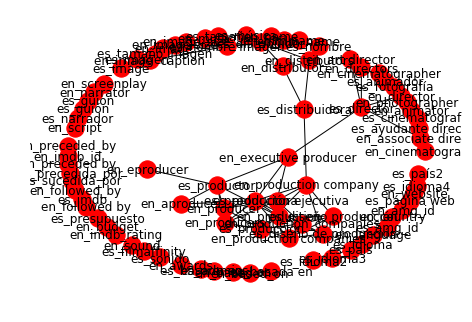

In [614]:
%matplotlib inline

nx.draw(G,with_labels=True)


In [615]:
c = 0
while G.edges():
    p = sorted(G.edges(data=True), key=lambda x: x[2]['w'])[0]
    psorted = sorted(list(p[:2]))
    print(psorted[0][3:],'->',psorted[1][3:])
    G.remove_node(p[0])
    G.remove_node(p[1])
    c+=1
print(c/len(template1['params']))

producer -> productor
music -> música
director -> director
production -> producción
awards -> premios
screenplay -> guion
language -> idioma
country -> país
preceded_by -> precedida_por
preceded by -> sucedida_por
narrator -> narrador
name -> nombre
website -> página web
distributor -> distribuidora
budget -> presupuesto
sound -> sonido
image size -> tamaño imagen
executive producer -> producción ejecutiva
production company -> diseño producción
production_companies -> diseño de producción
image -> imagen
photographer -> fotografía
imdb_rating -> imdb
producers -> productora
animator -> animador
distributors -> distribuidor
cinematography -> cinematografía
based on -> basado en
amg_id -> amg_id
associate director -> ayudante dirección
image_size -> tamaño
based_on -> basada en
script -> guión
image  caption -> nombre imagen
0.3695652173913043


#### Download top 100 templates in 'es' to 'en

In [637]:
import networkx as nx
G= nx.Graph()
output = {}
transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')

for exampleTemplate2 in  templateFreq[0:50]:
    try:
        exampleTemplate2 = exampleTemplate2[0]
        sourceLang2 ='es'
        targetLang2 = 'en'
        templatesTwoLang2 = getWikidataPair(['Plantilla:'+exampleTemplate2],sourceLang2,targetLang2)[0]


        distancesNoTemplateData = {}
        print(templatesTwoLang2)
        template1 = templates[templatesTwoLang2[0].split(':')[1]]
        #template1['params'] = sorted(template1['Params'].items(), key= lambda x: x[1],reverse=True)[:400]
        template1['params'] = [x for x in template1['Params'].items() if x[1]/len(template1['Params']) > .3] #appears at least X% of times
        template2 = templatesTarget[templatesTwoLang2[1].split(':')[1]]
        #template2['params'] = sorted(template2['Params'].items(), key= lambda x: x[1],reverse=True)[:400]
        template2['params'] = [x for x in template2['Params'].items() if x[1]/len(template2['Params']) > .05] #appears at least 1X of times


        for param1,data1 in template1['params']:
            try:
                vec1 = myModel.get_sentence_vector(param1.strip().replace('_',' '))
                distancesNoTemplateData[param1] = []
            except: pass
            for param2,data2 in template2['params']:
                    try:
                        vec2= myModel2.get_sentence_vector(param2.strip().replace('_',' '))
                        vec2T = apply_transform(vec2,transmat)
                        dist = distance.cosine(vec1,vec2T)
                        distancesNoTemplateData[param1].append([dist,param2])
                        if dist < .45:
                            node1= '%s_%s' % (sourceLang2,param1)
                            node2= '%s_%s' % (targetLang2,param2)
                            G.add_edge(node1,node2)
                            G[node1][node2]['w'] = dist
                    except:
                        pass    
        output[exampleTemplate2] = []
        print(exampleTemplate2,'======================')
        while G.edges():
            p = sorted(G.edges(data=True), key=lambda x: x[2]['w'])[0]
            psorted = sorted(list(p[:2]))
            output[exampleTemplate2].append({sourceLang2:psorted[0][3:],targetLang2:psorted[1][3:],'d':p[2]['w']})
            #print(psorted[0][3:],'->',psorted[1][3:])

            G.remove_node(p[0])
            G.remove_node(p[1])

    except:
        pass

['Plantilla:Listaref', 'Template:Reflist']
Listaref ======================
['Plantilla:Cita web', 'Template:Cite web']
Cita web ======================
['Plantilla:Ficha de taxón', 'Template:Taxobox']
Ficha de taxón ======================
['Plantilla:Cita libro', 'Template:Cite book']
Cita libro ======================
['Plantilla:Ficha de deportista', 'Template:Infobox sportsperson']
Ficha de deportista ======================
['Plantilla:Cita publicación', 'Template:Cite journal']
Cita publicación ======================
['Plantilla:Cita noticia', 'Template:Cite news']
Cita noticia ======================
['Plantilla:Ficha de persona', 'Template:Infobox person']
Ficha de persona ======================
['Plantilla:Coord', 'Template:Coord']
Coord ======================
['Plantilla:Referencias', 'Template:Unreferenced']
Referencias ======================
['Plantilla:Commonscat', 'Template:Commons category']
Commonscat ======================
['Plantilla:Enlace roto', 'Template:Dead link']
Enl

/srv/home/dsaez/3.6/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


['Plantilla:Cita requerida', 'Template:Citation needed']
Cita requerida ======================
['Plantilla:Ficha de estación', 'Template:Infobox station']
Ficha de estación ======================
['Plantilla:Ficha de cuerpo de agua', 'Template:Infobox body of water']
Ficha de cuerpo de agua ======================


In [641]:
with open('templatesEsEN-top100.json','w') as o:
    json.dump(output,o)

## Value based - In progress

In [551]:
import networkx as nx
G= nx.Graph()
exampleTemplate2 = 'Ficha de persona'
sourceLang2 ='es'
targetLang2 = 'en'
templatesTwoLang2 = getWikidataPair(['Plantilla:'+exampleTemplate2],sourceLang2,targetLang2)[0]

import random
random.seed(1)
pagesSource = random.sample(templates[exampleTemplate2]["Tpages"],50)
pagesPairs = getWikidataPair(pagesSource,sourceLang,targetLang)
templatesPairsPerPage = {}
for pages in pagesPairs:
    templateSource = [(name,data) for name,data in  extract_templates(getContent(pages[0],sourceLang)).items() if name.lower() in templatesTwoLang[0].lower()] 
    templateTarget = [(name,data) for name,data in  extract_templates(getContent(pages[1],targetLang)).items() if name.lower() in templatesTwoLang[1].lower()] 
    if templateSource:
        if templateTarget:
            templatesPairsPerPage[pages[0]] = templatesPairsPerPage.get(pages[0],[])

            templatesPairsPerPage[pages[0]].append((templateSource,templateTarget))
            
            


transmat = np.loadtxt('fastText_multilingual/my_alingments/apply_in_en_to_es.txt')

for pages, data in templatesPairsPerPage.items():
    pageSourceLang = data[0][0][0][1]
    pageTargetLang = data[0][1][0][1]
    for param1,value in pageSourceLang.items():
        try:
            vec1 = myModel.get_sentence_vector(value.strip())
            distancesNoTemplateData[param1] = []
            for param2,value2 in pageTargetLang.items():
                    vec2= myModel2.get_sentence_vector(value2.strip())
                    vec2T = apply_transform(vec2,transmat)
                    dist = distance.cosine(vec1,vec2T)
                    distancesNoTemplateData[param1].append([dist,param2])
        except:
            pass


['Plantilla:Ficha de persona', 'Template:Infobox person']


/srv/home/dsaez/3.6/lib/python3.5/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [556]:
cNotFound = 0
for param,words in distancesNoTemplateData.items():
    try:
        if sorted(words)[0][0] < .9:
            print(param,sorted(words)[0:3])
        else:
            cNotFound +=1
    except:
        pass

tiempo [[0.8237192646115215, 'years_active'], [0.8297616419425919, 'name'], [0.8372941016593429, 'children']]
pie de imagen [[0.595959560523716, 'image'], [0.6550599889689077, 'other_names'], [0.7264075447081769, 'movement']]
nombre [[0.4041053071307944, 'image'], [0.518457326659189, 'other_names'], [0.7447650042056859, 'citizenship']]
nacionalidad [[0.6498525538332381, 'death_date'], [0.6839225568797711, 'death_place'], [0.6960114454594034, 'birth_place']]
alma máter [[0.6260514271654607, 'image'], [0.6876603840579052, 'other_names'], [0.6956217498859136, 'movement']]
tamaño [[0.6252674964760204, 'death_date'], [0.6543020957305372, 'birth_date'], [0.6881550150885685, 'alma_mater']]
lugar de nacimiento [[0.6006641143067445, 'movement'], [0.651721071660169, 'citizenship'], [0.749902622171667, 'image']]
website [[0.14517355546728405, 'website'], [0.33303012814333954, 'residence'], [0.4358272801220364, 'caption']]
nombre de nacimiento [[0.5268444887815582, 'image'], [0.561234729287486, 'o